In [1]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Settings
methods = ["ele","da","jb","sig","esig"]
method = methods[0]
eBeam = 5
pBeam = 41
beamConfig = f"{eBeam}x{pBeam}"
binning = 'StandardBinning' # 'HeraBinning' 
target_lumi = 10. # target luminosity in fb-1
e_finder_efficiency = 0.95 # 95% efficiency

In [3]:
f = ROOT.TFile.Open(f"../Yields/yield_histograms_podio_{binning}_{beamConfig}.root")

In [4]:
def hist_to_df(h_gen, h_rec, h_gen_rec, centres_df=None):

    nx = h_gen.GetNbinsX()
    ny = h_gen.GetNbinsY()

    if centres_df is None:
        # Build from ROOT log-spaced bin edges
        rows = []


        for iy in range(1, ny+1):
            Q2_low  = h_gen.GetYaxis().GetBinLowEdge(iy)
            Q2_high = h_gen.GetYaxis().GetBinUpEdge(iy)
            if Q2_low <= 0 or Q2_high <= 0:
                continue
                                
            Q2_centre = 10**((np.log10(Q2_low) + np.log10(Q2_high)) / 2)

            for ix in range(1, nx+1):
                x_low  = h_gen.GetXaxis().GetBinLowEdge(ix)
                x_high = h_gen.GetXaxis().GetBinUpEdge(ix)
                if x_low <= 0 or x_high <= 0:
                    continue
            
                x_centre = 10**((np.log10(x_low) + np.log10(x_high)) / 2)



                rows.append({
                    "Q2_centre": Q2_centre,
                    "x_centre":  x_centre
                })

        centres_df = pd.DataFrame(rows)

    else:
        # Ensure required columns exist
        if not {"x_centre", "Q2_centre"}.issubset(centres_df.columns):
            raise ValueError("centres_df must contain: x_centre, Q2_centre")

        centres_df = centres_df.copy().reset_index(drop=True)


    centres_df["y"] = centres_df["Q2_centre"] / (4. * eBeam * pBeam * centres_df["x_centre"])

    # Apply y cuts (only matters if not specifying binning scheme)
    centres_df = centres_df[
        (centres_df["y"] >= 0.005) &
        (centres_df["y"] <= 0.95)
    ].reset_index(drop=True)

    data = []

    # Get values from histograms
    for _, row in centres_df.iterrows():

        x_c = row["x_centre"]
        Q2_c = row["Q2_centre"]

        # Find ROOT bins
        bin_x = h_gen.GetXaxis().FindBin(x_c)
        bin_y = h_gen.GetYaxis().FindBin(Q2_c)

        gen     = h_gen.GetBinContent(bin_x, bin_y)
        rec     = h_rec.GetBinContent(bin_x, bin_y)
        rec = rec*e_finder_efficiency
        gen_rec = h_gen_rec.GetBinContent(bin_x, bin_y)

        if gen == 0:
            continue

        purity    = gen_rec / rec if rec > 0 else 0
        stability = gen_rec / gen if gen > 0 else 0

        data.append({
            "Q2": Q2_c,
            "x": x_c,
            "y": row["y"],
            "gen": gen,
            "rec": rec,
            "gen_rec": gen_rec,
            "purity": purity,
            "stability": stability
        })

    return pd.DataFrame(data)



In [5]:
df_dict = {} 
for method in methods:
    
    binning_file = None
    binning_df = None
    if binning != 'StandardBinning':
        binning_file = f"../BinCentres/{binning}_eic{beamConfig}.txt"
        binning_df = pd.read_csv(binning_file, sep='\s+')
    
    # Histogram names 
    h_gen_name = "hQ2vsX_yield_gen"
    h_rec_name = f"hQ2vsX_yield_rec_{method}"
    h_gen_rec_name = f"hQ2vsX_yield_gen_rec_{method}"
    
    # Get histograms 
    h_gen = f.Get(h_gen_name)
    h_rec = f.Get(h_rec_name)
    h_gen_rec = f.Get(h_gen_rec_name) 
    
    df_dict[method] = hist_to_df(h_gen,h_rec,h_gen_rec,binning_df)

In [6]:
df_dict["ele"]

,Q2,x,y,gen,rec,gen_rec,purity,stability
0,1.258925,0.001995,0.769460,4.634915e+07,3.107802e+07,2.826037e+07,0.909336,0.609728
1,1.258925,0.003162,0.485497,7.481432e+07,6.668335e+07,5.475309e+07,0.821091,0.731853
2,1.258925,0.005012,0.306328,9.214961e+07,9.735445e+07,6.993744e+07,0.718379,0.758955
3,1.258925,0.007943,0.193280,1.118488e+08,1.168375e+08,7.879675e+07,0.674413,0.704494
4,1.258925,0.012589,0.121951,1.247757e+08,1.311817e+08,7.351524e+07,0.560408,0.589179
...,...,...,...,...,...,...,...,...
94,199.526231,0.501187,0.485497,1.841277e+05,1.344364e+05,1.271453e+05,0.945765,0.690528
95,199.526231,0.794328,0.306328,1.951199e+04,1.631456e+04,1.314721e+04,0.805857,0.673801
96,316.227766,0.501187,0.769460,9.393487e+04,6.303643e+04,6.094156e+04,0.966767,0.648764
97,316.227766,0.794328,0.485497,1.030728e+04,7.570084e+03,6.030675e+03,0.796646,0.585089


In [7]:
def get_bin_edges_from_hist(hist):
    """Return numpy arrays of x and Q2 bin edges from 2D ROOT histogram."""
    import numpy as np
    
    xaxis = hist.GetXaxis()
    yaxis = hist.GetYaxis()
    
    nx = xaxis.GetNbins()
    ny = yaxis.GetNbins()
    
    x_edges = np.array([xaxis.GetBinLowEdge(i) for i in range(1, nx+2)])
    Q2_edges = np.array([yaxis.GetBinLowEdge(i) for i in range(1, ny+2)])
    
    return x_edges, Q2_edges


In [8]:
x_edges, Q2_edges = get_bin_edges_from_hist(h_gen) # need h_gen to be defined

In [9]:
Q2_edges

array([1.00000000e+00, 1.58489319e+00, 2.51188643e+00, 3.98107171e+00,
       6.30957344e+00, 1.00000000e+01, 1.58489319e+01, 2.51188643e+01,
       3.98107171e+01, 6.30957344e+01, 1.00000000e+02, 1.58489319e+02,
       2.51188643e+02, 3.98107171e+02, 6.30957344e+02, 1.00000000e+03,
       1.58489319e+03, 2.51188643e+03, 3.98107171e+03, 6.30957344e+03,
       1.00000000e+04, 1.58489319e+04])

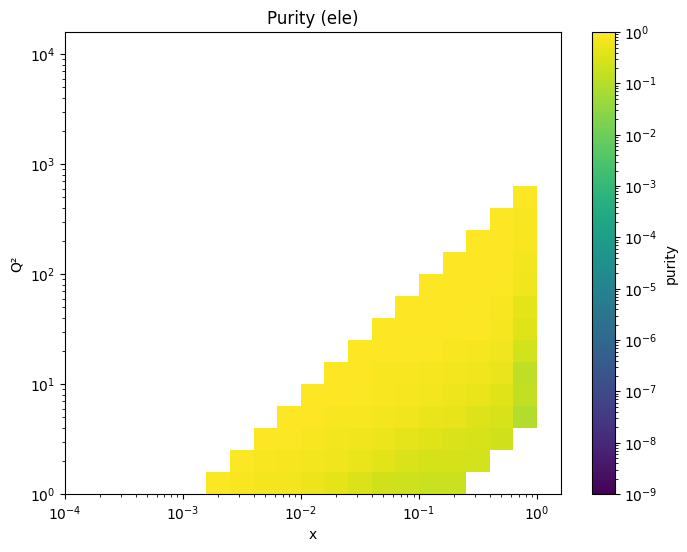

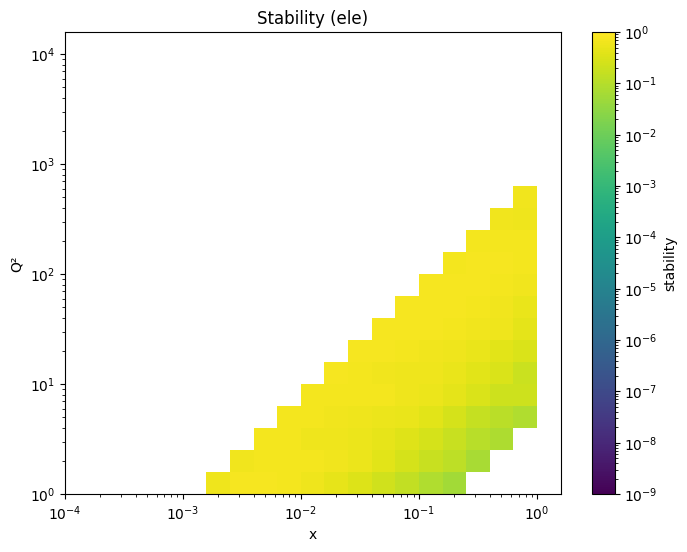

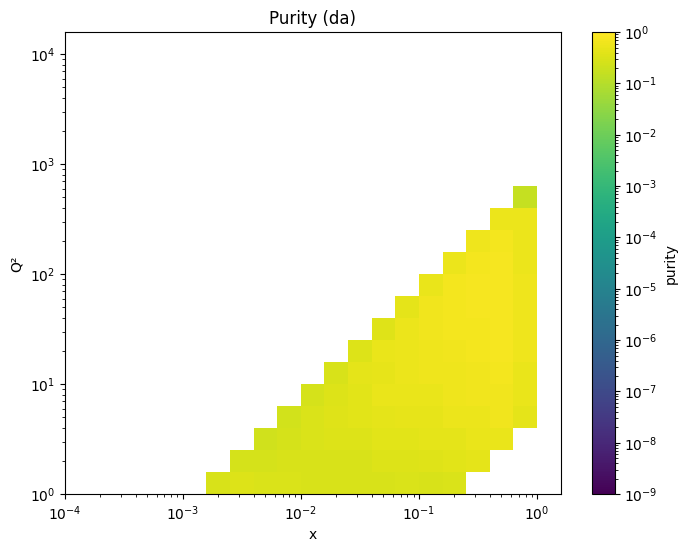

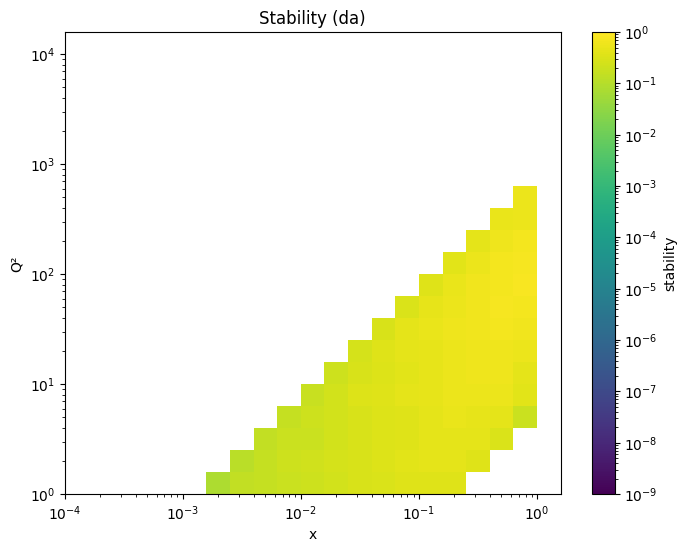

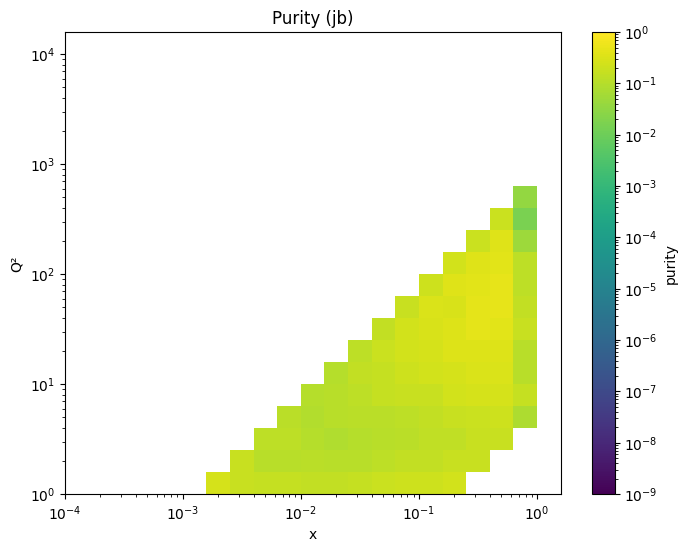

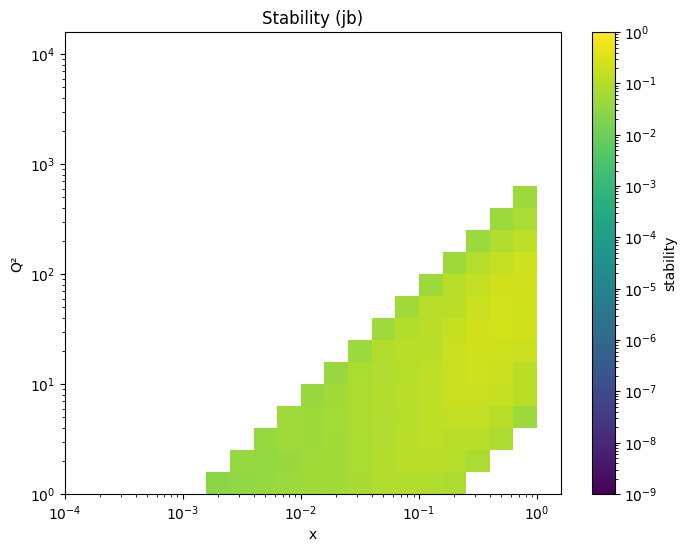

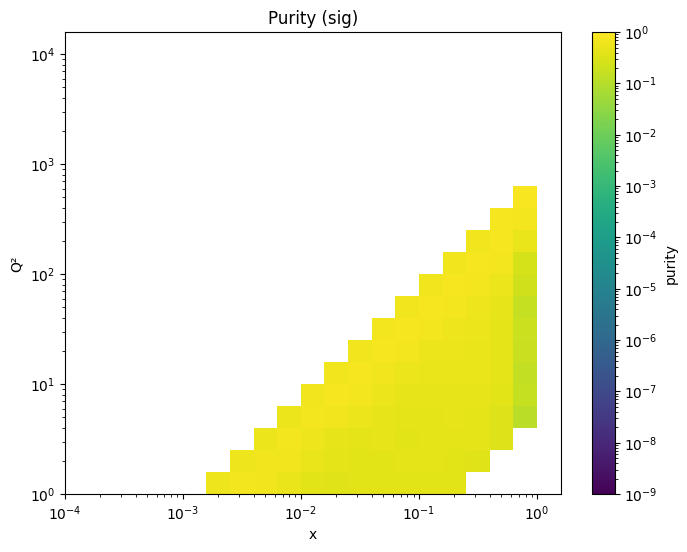

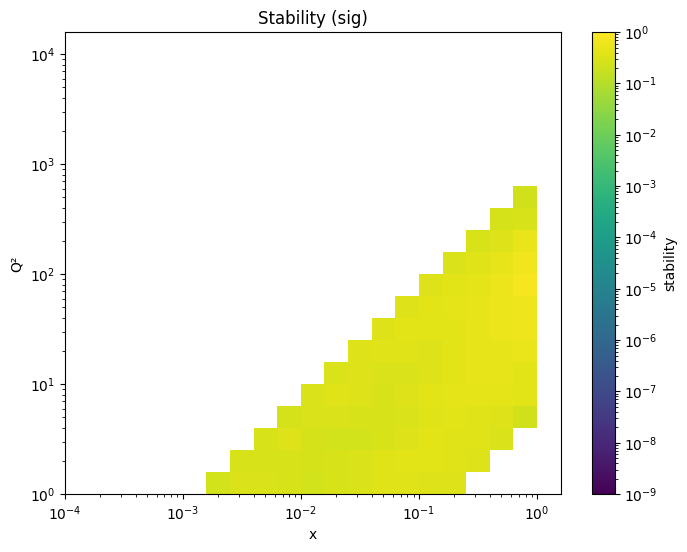

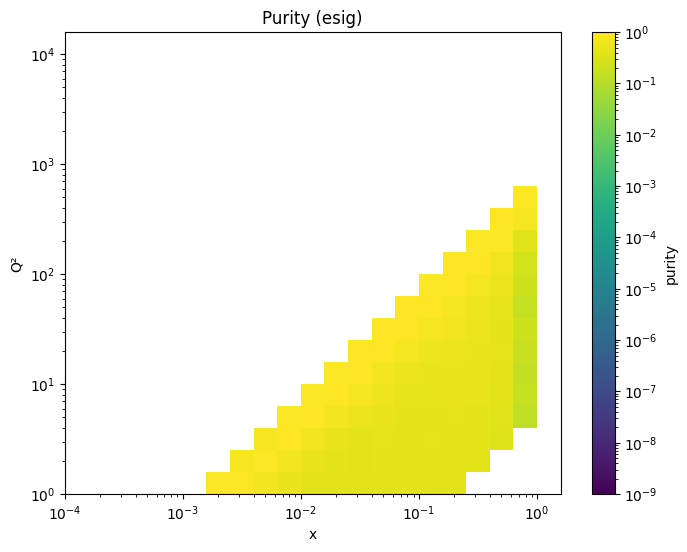

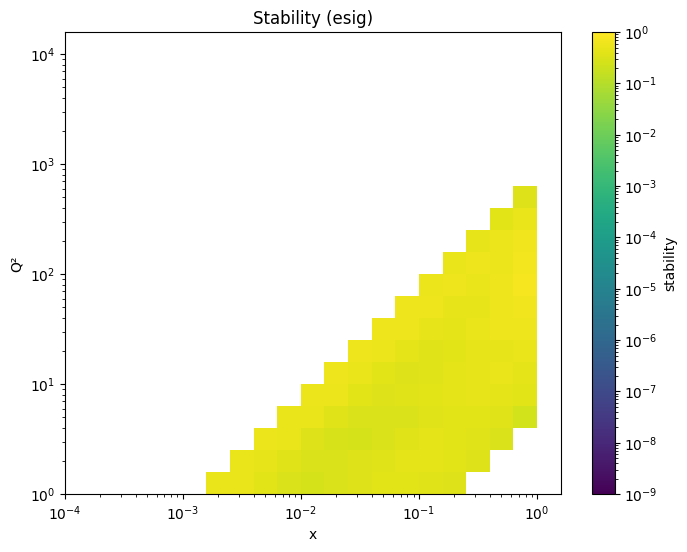

In [10]:
from matplotlib.colors import LogNorm
def plot_quantity(df, expression, title, x_edges, Q2_edges, zmin=1e-9, zmax=1):
    """
    Plot a 2D heatmap using ROOT bin edges from argument.
    The df only needs x, Q2, and the columns used in expression.
    Missing bins remain NaN.
    """
    nx = len(x_edges) - 1
    ny = len(Q2_edges) - 1

    # Prepare a grid of NaNs
    Z = np.full((ny, nx), np.nan)

    # Evaluate the expression
    values = df.eval(expression).values

    # Loop over DF rows and assign each point to the correct bin
    for (x, Q2, val) in zip(df["x"], df["Q2"], values):

        # determine bin index from edges
        ix = np.searchsorted(x_edges, x) - 1
        iy = np.searchsorted(Q2_edges, Q2) - 1

        # skip out-of-range points
        if ix < 0 or ix >= nx: 
            continue
        if iy < 0 or iy >= ny:
            continue

        Z[iy, ix] = val  # fill the grid

    # Make meshgrid for pcolormesh
    X, Y = np.meshgrid(x_edges, Q2_edges)

    plt.figure(figsize=(8,6))
    # mesh = plt.pcolormesh(X, Y, Z, shading="auto", vmin=zmin, vmax=zmax) for lin scale
    mesh = mesh = plt.pcolormesh( # for log scale
    X, Y, Z,
    shading="auto",
    norm=LogNorm(vmin=zmin, vmax=zmax)
)

    
    plt.colorbar(mesh, label=expression)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("x")
    plt.ylabel("Q²")
    plt.title(title)
    plt.show()


for method, df in df_dict.items():
    plot_quantity(df, "purity", f"Purity ({method})", x_edges, Q2_edges)
    plot_quantity(df, "stability", f"Stability ({method})", x_edges, Q2_edges)


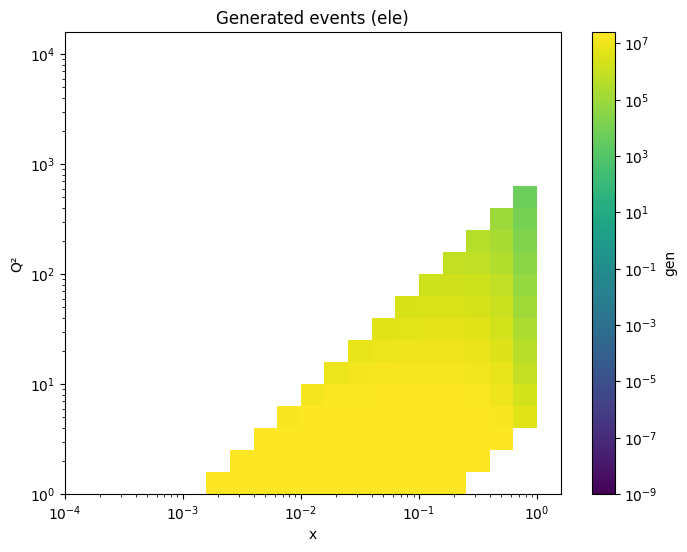

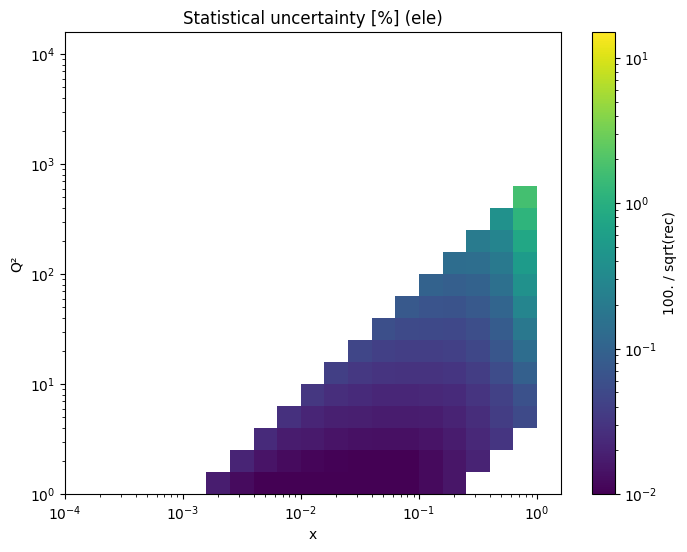

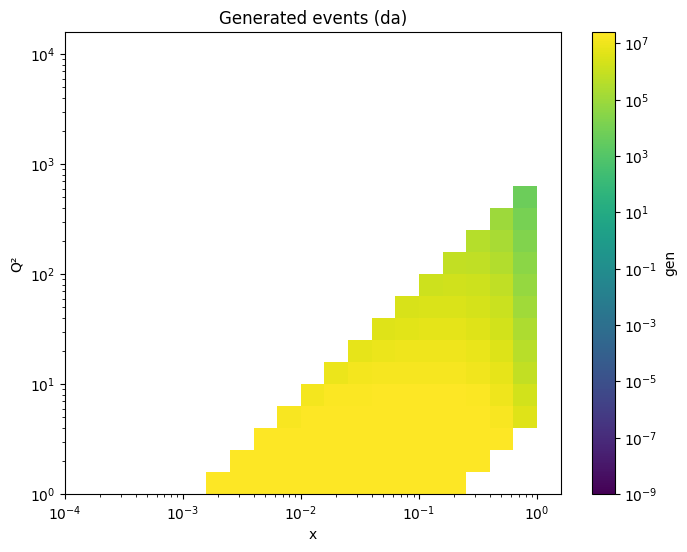

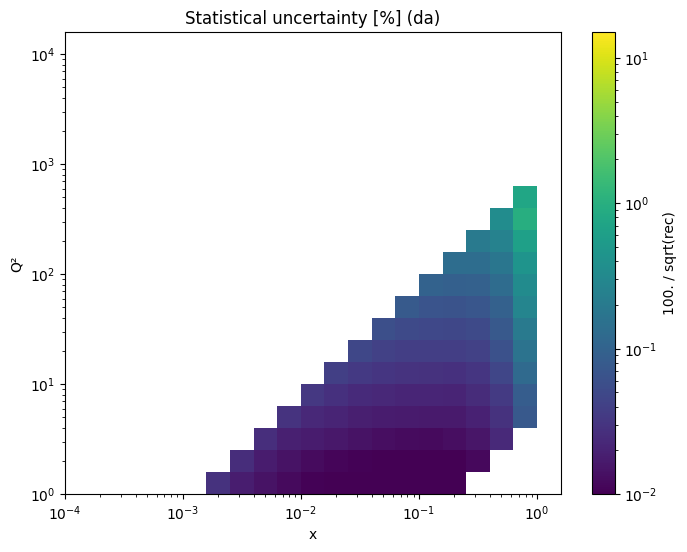

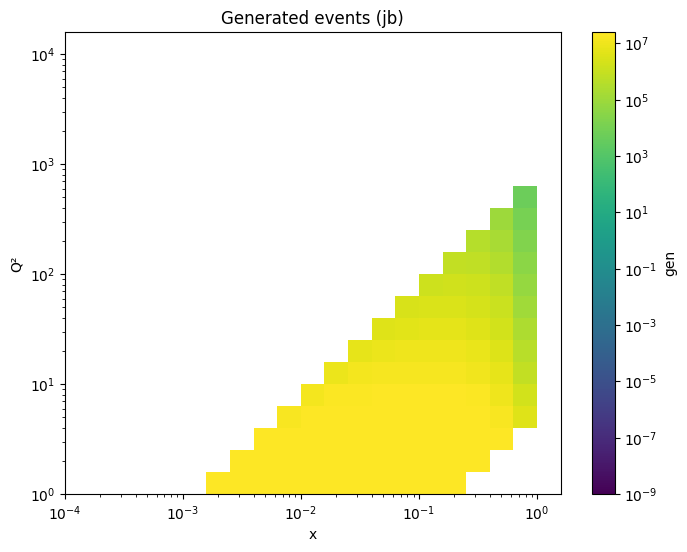

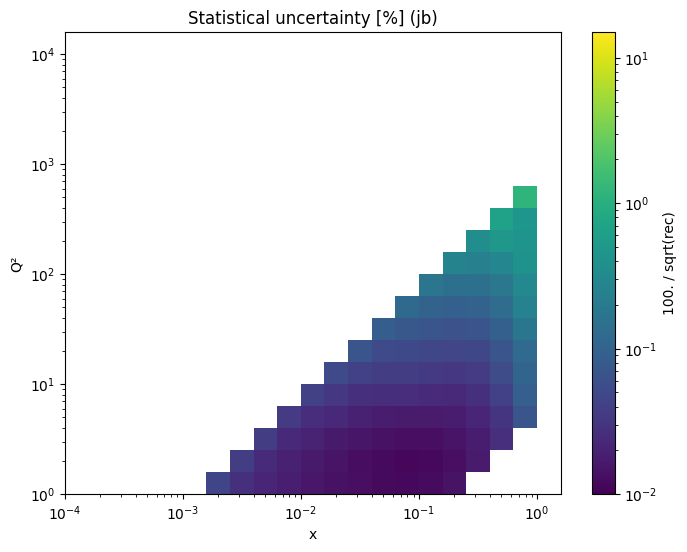

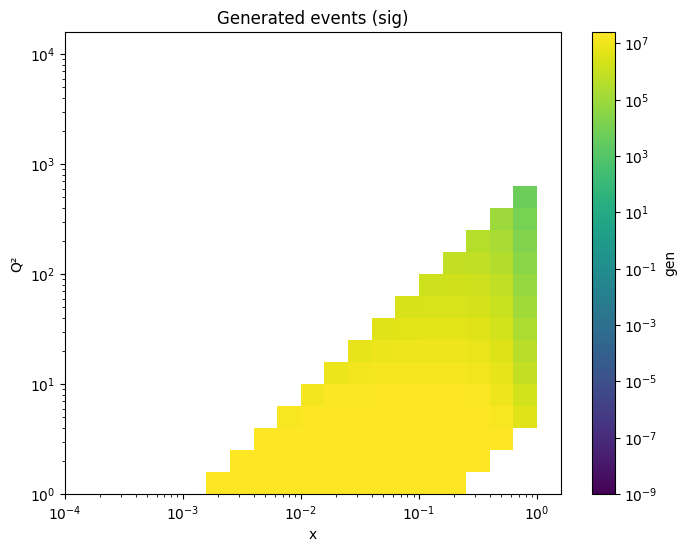

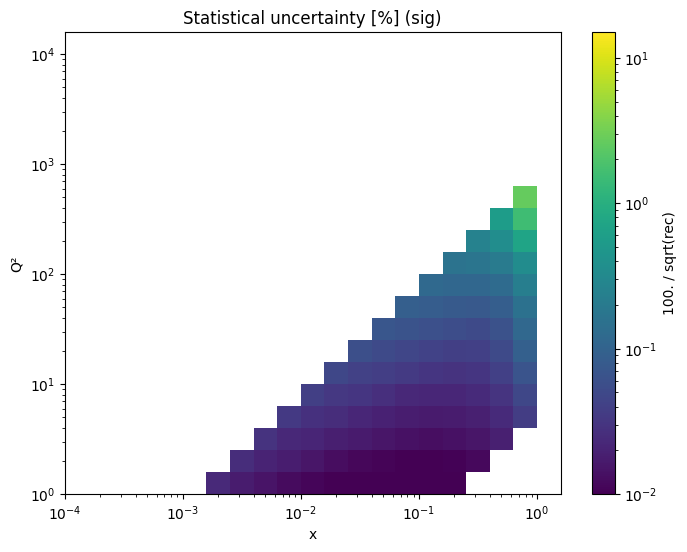

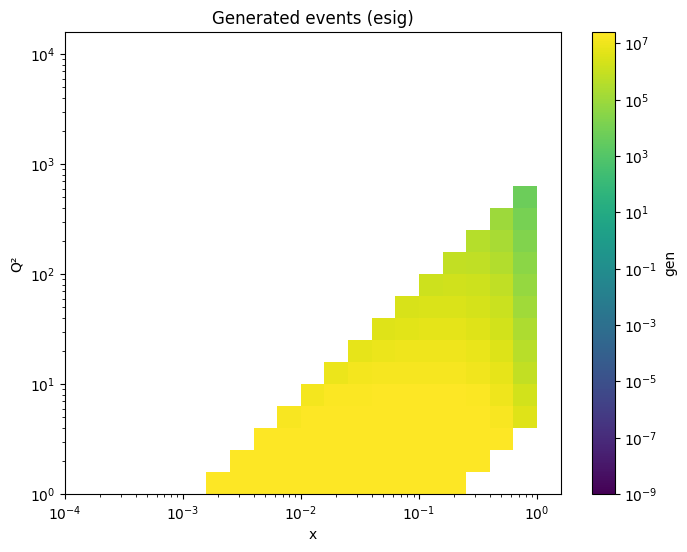

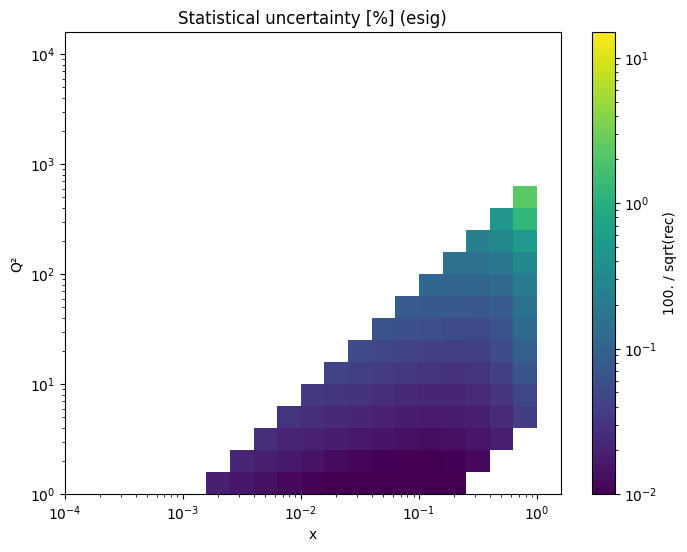

In [11]:
# Plot other quantities if desired
for method, df in df_dict.items():
    plot_quantity(df, "gen", f"Generated events ({method})", x_edges, Q2_edges,zmax=2.5e7)
    plot_quantity(df, "100. / sqrt(rec)", f"Statistical uncertainty [%] ({method})", x_edges, Q2_edges,zmin=1e-2,zmax=15)

In [12]:
import re

def extract_luminosity(hist):
    title = hist.GetTitle()
    match = re.search(r"Luminosity = ([\d\.]+) fb-1", title)
    
    if match:
        lumi_fb = float(match.group(1))  # Extract value
        return lumi_fb
    else:
        return None  # Return None if pattern is not found

# Scaling factor for number of events to target luminosity
gen_lumi = extract_luminosity(h_gen)
lumi_scale_factor = target_lumi / gen_lumi

In [13]:
# Scale events and save dataframes
for method in methods:
    cols_to_scale = ['gen', 'rec', 'gen_rec'] # columns that scale with luminosity
    df_dict[method][cols_to_scale] = df_dict[method][cols_to_scale] * lumi_scale_factor
    df_dict[method].to_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_lumi{target_lumi}fb-1_bins.csv",index=False)